In [59]:
# import libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt', quiet=True) # download punkt (if not already downloaded)
from nltk import word_tokenize, sent_tokenize
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# change this to your own data directory
data_dir = "data/"

# read and preprocess data
text_file_name = "osdg-community-data-v2023-01-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
col_names = text_df.columns.values[0].split('\t')
text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
text_df.drop(text_df.columns.values[0], axis=1, inplace=True)

2024-07-16 14:17:11.584396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Solutions to Exercises: Sections 1 to 4

## Preprocessing

**Exercise 1.1**

Answers may vary.

**Exercise 1.2**

Answers may vary.

**Exercise 1.3**
The following code removes any rows that contain only N/A values. In this case, there are no such rows to remove.

In [3]:
nrows_old = text_df.shape[0]
text_df.dropna(axis=0, how='all', inplace=True)
print("Number of rows removed:", nrows_old - text_df.shape[0])

Number of rows removed: 0


The next line of code checks for the existence of any remaining N/A values. It turns out that there are none.

In [4]:
text_df.isna().any()

doi                False
text_id            False
text               False
sdg                False
labels_negative    False
labels_positive    False
agreement          False
dtype: bool

Whether or not entries with N/A values should be removed depends on the dataset and the nature of the problem. Sometimes, entries with N/A values should be dropped, while at other times, they should be kept unchanged, or replaced with interpolated or placeholder values. Consult [the `pandas` documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) for more information about how to deal with missing values in dataframes.

**Exercise 1.4**

After filtering the dataset, we inspect it using the `info()` function.

In [2]:
# filter the dataset
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
text_df.reset_index(inplace=True, drop=True)

# inspect it
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24669 entries, 0 to 24668
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doi              24669 non-null  object 
 1   text_id          24669 non-null  object 
 2   text             24669 non-null  object 
 3   sdg              24669 non-null  int64  
 4   labels_negative  24669 non-null  int64  
 5   labels_positive  24669 non-null  int64  
 6   agreement        24669 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.3+ MB


We have 40062 entries with 7 features (see [section 0](sec0_data.ipynb) for details). The data types range from `object` (likely denoting strings) to `int64` (integers) to `float64` (floating-point numbers). This is a reasonable amount of data to work with.

**Exercise 1.5**

The Porter and Snowball stemmers are largely comparable, while the Lancaster stemmer is the most aggressive. As a result, the Lancaster stemmer is likely to have the most trouble on a larger set of tokens.

**Exercise 1.6**

Answers may vary. Some possible observations include the fact that stemmers tend to remove affixes (such as `-ing`, `-ed`, and `-s` in English) and the fact that irregular words are particularly likely to give the stemmers trouble.

**Exercise 1.7**

Answers may vary.

**Exercise 1.8**

Answers may vary. Some possible entity labels include `GPE` ("nationalities or religious or political groups"), `TIME` ("times smaller than a day"), `QUANTITY` ("measurements, as of weight or distance"), and `WORK_OF_ART` ("titles of books, songs, etc.").

**Exercise 1.9**

Sample code solution:

In [37]:
# load trained pipeline
nlp = spacy.load('en_core_web_sm')

# perform NER on random sample in both original and lower case
sample = text_df['text'].sample(1).values[0]
doc = nlp(sample)
print('ORIGINAL CASE')
spacy.displacy.render(doc, style='ent', jupyter=True)
print('\nLOWERCASE')
doc = nlp(sample.lower())
spacy.displacy.render(doc, style='ent', jupyter=True)

ORIGINAL CASE



LOWERCASE


Answers may vary depending on the samples chosen. This sample demonstrates that the model sometimes confuses organizations with people. Additionally, it shows that the model often fails to recognize organization names (especially abbreviated ones) when they are converted to lowercase.

**Exercise 1.10**

Answers may vary.

## About Text Data

**Exercise 2.1**

In [3]:
# get document-term matrix
docs = text_df.text
cv = CountVectorizer()
cv_fit = cv.fit_transform(docs)

# get feature names and total counts
feature_names = cv.get_feature_names_out()
total_counts = cv_fit.sum(axis=0)

# get the index of the most frequent word
most_freq_feature = total_counts.argmax()

# get the most frequent word itself
most_freq_token = feature_names[most_freq_feature]
print(f"Most frequent word: '{most_freq_token}'")

Most frequent word: 'the'


**Exercise 2.2**

In [4]:
# get document-term matrix with stop words removed
cv2 = CountVectorizer(stop_words='english') # exclude English stop words
cv2_fit = cv2.fit_transform(text_df.text)

original_len = len(cv.vocabulary_) # length of the original vocabulary (with stop words)
new_len = len(cv2.vocabulary_) # length of the new vocabulary (without stop words)
stopwords = cv2.get_stop_words()

print('Length of the original vocabulary (with stop words):', original_len)
print('Length of the new vocabulary (without stop words):', new_len)
print('Number of stop words:', len(stopwords))
print('Difference between original and new vocabularies:', original_len - new_len)

Length of the original vocabulary (with stop words): 45738
Length of the new vocabulary (without stop words): 45440
Number of stop words: 318
Difference between original and new vocabularies: 298


The difference between the original and new vocabularies is less than the number of stop words. This is because not all of the stop words actually occur in the original vocabulary. The following code lists the stop words that are missing from the original vocabulary. Note how the difference between the original and new vocabulary lengths (298) added to the number of missing stopwords (20) is equal to the total number of stop words (318).

In [5]:
missing_stopwords = stopwords - cv.vocabulary_.keys()
print(f'{len(missing_stopwords)} missing stopwords:', missing_stopwords)

20 missing stopwords: {'whereafter', 'whence', 'noone', 'thereupon', 'i', 'thence', 'a', 'latterly', 'yours', 'whereupon', 'couldnt', 'whoever', 'anyhow', 'hasnt', 'whither', 'hers', 'amoungst', 'hereupon', 'yourselves', 'beforehand'}


**Exercise 2.3**

In [6]:
# get feature names and total counts
feature_names = cv2.get_feature_names_out()
total_counts = cv2_fit.sum(axis=0)

# get the index of the most frequent word
most_freq_feature = total_counts.argmax()

# get the most frequent word itself
most_freq_token = feature_names[most_freq_feature]
print(f"Most frequent word: '{most_freq_token}'")

Most frequent word: 'countries'


**Exercise 2.4**

First, we fit the one-hot encoder to the sample text.

In [7]:
sample_text = text_df.text.iloc[12737].lower()
tokens = nltk.word_tokenize(sample_text)

def ohe_reshape(tokens):
    return np.asarray(tokens).reshape(-1,1)

ohe = OneHotEncoder(handle_unknown='ignore') # encode unknown tokens as vectors of all zeros
ohe.fit(ohe_reshape(tokens));

Next, we transform each token only once by using a set to remove duplicates.

In [8]:
token_set = list(set(tokens))
encodings = ohe.transform(ohe_reshape(token_set)).toarray() # encode the tokens

There are multiple ways to check that the resulting encodings are unique, but one simple way is to use the `pandas` library. The following code transforms the encodings into a `pandas` dataframe and then verifies that there are no duplicates. This confirms that each learned token has a unique encoding.

In [9]:
pd.DataFrame(encodings).duplicated().any()

False

**Exercise 2.5**

In [10]:
print('SDG:', text_df.sdg.iloc[118])
print('Text:', text_df.text.iloc[118])

SDG: 5
Text: "Female economic activities were critically examined and new light was shed on existing conceptions of traditional housework. Oxford University Press, 2007). An edited version of Ihe chapter is available al www.rci.rutgers.edu/~cwgl/globalcenler/charlotte/UN-Handbook.pdf. Targets were also set for the improvement of women's access to economic, social and cultural rights, including improvements in health, reproductive services and sanitation. The women in development approach is embodied in article 14 of the Convention, which focuses on rural women and calls on States to ensure that women ""participate in and benefit from rural development"" and also that they ""participate in the elaboration and implementation of development planning at all levels"".15 Participation is an important component of the right to development, as discussed below."


The most frequent words are "women" and "development", which occur 4 times each. This, together with the label of SDG 5 (gender equality), suggests that this document is about equality for women.

**Exercise 2.6**

Each token in a given document, except for the first and last, is grouped into two different bigrams (one with the previous token, and another with the next token). In this case, the large number of distinct bigrams in the entire corpus likely leads to a bigram vocabulary that is larger than the corresponding unigram vocabulary. However, many of the unigrams may occur more often than many of the bigrams do, making the total count of bigrams smaller than the total count of unigrams.

**Exercise 2.7**

In [11]:
count_vectorizer = CountVectorizer(ngram_range=(3,3), stop_words='english') 
count_vector = count_vectorizer.fit_transform(docs)
print('Total count of trigrams (without stop words):', count_vector.sum())
print('Number of unique trigrams (without stop words):', len(count_vectorizer.vocabulary_))

Total count of trigrams (without stop words): 1301713
Number of unique trigrams (without stop words): 1214215


The total count of trigrams is smaller than the total count of bigrams, but the number of unique trigrams is larger than the total number of unique bigrams. The explanation for this is similar to the reasoning offered in the solution to the previous exercise, but substituting bigrams for unigrams and trigrams for bigrams.

**Exercise 2.8**

Answers may vary depending on the sentences chosen.

**Exercise 2.9**

In [13]:
tp = 398
fp = 153
fn = 83

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall)/(precision + recall)

print(f'Precision = {precision}, recall = {recall}, f1 = {f1}')

Precision = 0.7223230490018149, recall = 0.8274428274428275, f1 = 0.7713178294573643


**Exercise 2.10**

Answers may vary depending on the parameters chosen. Here is a sample answer using the parameters `ngram_range = (2,2)` (for bigrams), `stop_words = 'english'`, and `min_df = 3`.

In [30]:
docs = text_df.text
count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', min_df=3)
count_vector = count_vectorizer.fit_transform(docs).toarray()
term_freq = pd.DataFrame({"term": count_vectorizer.get_feature_names_out(), "freq" : count_vector.sum(axis=0)})

# find the frequencies of the 5 most common bigrams
term_freq.sort_values(by='freq', ascending=False).iloc[0:5]

,term,freq
27774,human rights,1981
10071,climate change,1301
20488,et al,1167
40775,oecd countries,898
26527,health care,881


In [ ]:
docs = text_df.text
count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', min_df=3)
count_vector = count_vectorizer.fit_transform(docs).toarray()
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())

# find the frequencies of the 5 most common bigrams
term_freq.sort_values(by='freq', ascending=False).iloc[0:5]

**Exercise 2.11**

In [151]:
def analyze_frequency(corpus, stop_words=None):
    # create term-document matrix
    count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=stop_words)
    count_vector = count_vectorizer.fit_transform(corpus).toarray()
    
    # calculate frequencies of 50 most frequent terms
    freq_df = pd.DataFrame(
        {"term": count_vectorizer.get_feature_names_out(), "freq" : count_vector.sum(axis=0)}
    ).sort_values(by='freq', ascending=False)

    # calculate cumulative word counts
    csum = np.cumsum(freq_df.iloc[0:50].freq).values
    
    # create plot
    fig, ax = plt.subplots()
    plt.plot(csum)
    ax.set_ylabel('cumulative word count')
    ax.set_xlabel('rank')
    ax.set_title('Cumulative Word Count (Most Frequent to 50th Most Frequent)')
    
    # calculate comparison
    comp = csum[-1] / freq_df.freq.sum()
    
    return (freq_df.iloc[0:50], ax, f'{comp:.2%}')

**Exercise 2.12**

First, we obtain our corpus:

In [156]:
sdg8 = text_df[text_df.sdg == 8].text

Then we run the function from the previous exercise on that corpus and examine the results:

Level of cumulation percentage: 38.58%

Top 50 words:


,term,freq
6933,the,5400
4806,of,3294
636,and,3261
3578,in,2777
7000,to,2618
3018,for,1212
3842,is,1005
6932,that,745
712,are,734
4843,on,694


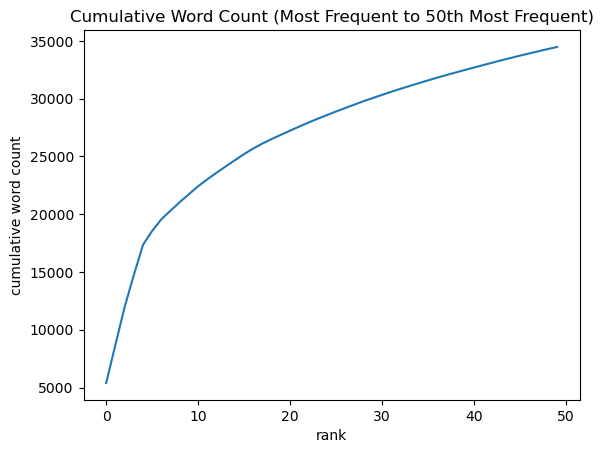

In [153]:
(top_50_words, plot, pct) = analyze_frequency(sdg8)

print('Level of cumulation percentage:', pct)
print()
print('Top 50 words:')
top_50_words

**Exercise 2.13**

With stop word removal:

Level of cumulation percentage: 12.27%

Top 50 words:


,term,freq
10295,countries,7761
44859,women,5984
12072,development,5312
19188,health,4685
44337,water,4664
33322,public,4591
38326,social,4538
13847,education,4535
31876,policy,4367
21846,international,4360


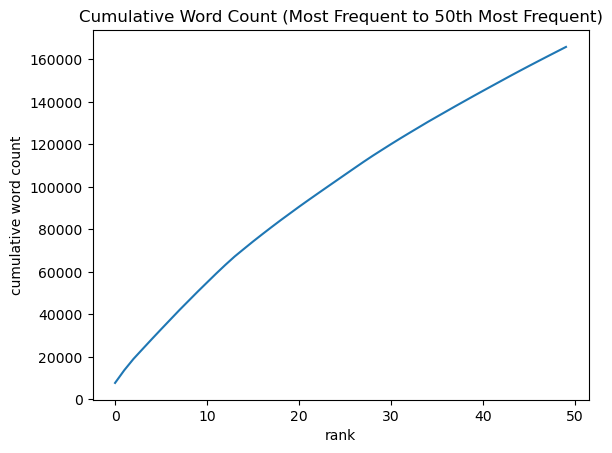

In [159]:
docs = text_df.text
(top_50_words, plot, pct) = analyze_frequency(docs, 'english')

print('Level of cumulation percentage:', pct)
print()
print('Top 50 words:')
top_50_words

Without stop word removal:

Level of cumulation percentage: 36.81%

Top 50 words:


,term,freq
41229,the,143100
29487,of,95834
3469,and,93357
20921,in,67152
41630,to,64701
16900,for,30010
22403,is,25175
41221,that,20395
4217,as,18926
29700,on,18365


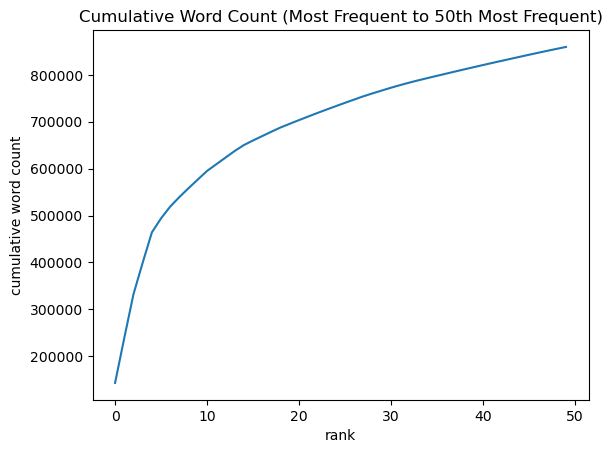

In [160]:
(top_50_words, plot, pct) = analyze_frequency(docs, None)

print('Level of cumulation percentage:', pct)
print()
print('Top 50 words:')
top_50_words

Frequent words that are not stop words, such as 'countries', 'women', and 'development', occur often enough to show up in both lists. As one might expect, stop words such as 'the', 'of', and 'and' occur much more frequently than terms that are not stop words. As a result, the level of cumulation percentage is much smaller and the cumulative word count curve is more linear with stop word removal than without stop word removal.

## Document Embedding

**Exercise 3.1**

After creating `sentence_df`, we can compare its dimensions to those of `text_df`.

In [9]:
def tokenize_into_sentences(corpus):
    corpus_sentence = []
    corpus_sdg = []
    corpus_sample = []
    for (text, sdg, i) in iter(zip(corpus.text, corpus.sdg, corpus.index)):
        sentences = nltk.sent_tokenize(text) 
        corpus_sentence += sentences
        corpus_sdg += [sdg]*len(sentences)
        corpus_sample += [i]*len(sentences)
    sentence_df = pd.DataFrame({"text": corpus_sentence, "sdg": corpus_sdg, "sample": corpus_sample})
    return sentence_df

sentence_df = tokenize_into_sentences(text_df)
print('text_df dimensions:', text_df.shape)
print('sentence_df dimensions:', sentence_df.shape)

text_df dimensions: (24669, 7)
sentence_df dimensions: (92839, 3)


The dimensions of `text_df` represent the number of sample texts and the number of features, respectively. The dimensions of `sentence_df`represent the number of sentences and the number of features, respectively.

**Exercise 3.2**

Student answers may vary. As a sample answer, we choose a text containing direct quotations, which can increase the difficulty of sentence tokenization:

In [72]:
text_df.text.loc[465]

'When asked “Have you no morals?” Alfred Doolittle in George Bernard Shaw’s Pygmalion answered: “Can’t afford them governor. Neither could you if you was as poor as me.” The modern concept of human rights underpins a moral society and holds governments responsible for fulfilling these rights. From informed consent to the right to privacy civil and political rights have dominated the human rights focus of the HIV-1 epidemic. Yet the economic and social rights of people with HIV-1 infection in particular the rights to health care and to share in scientific advances are glaringly disparate between rich and poor countries. This disparity has become the focus of debate in transnational HIV-1 vaccine research. (excerpt)'

Despite the increased difficulty, the sentence tokenizer is able to separate out the sentences correctly:

In [75]:
sentence_df[sentence_df['sample'] == 465]

,text,sdg,sample
1785,When asked “Have you no morals?” Alfred Doolit...,16,465
1786,Neither could you if you was as poor as me.” T...,16,465
1787,From informed consent to the right to privacy ...,16,465
1788,Yet the economic and social rights of people w...,16,465
1789,This disparity has become the focus of debate ...,16,465
1790,(excerpt),16,465


**Exercise 3.3**

Answers may vary depending on the samples chosen. For simplicity, this sample solution chooses two samples in `text_df` with the same number of sentences.

In [98]:
samples = text_df.loc[[32,6]]
sentences = tokenize_into_sentences(samples)
sentences

,text,sdg,sample
0,This points to the possibility that the effect...,1,32
1,One possible explanation for this is that incr...,1,32
2,These results are similar to those obtained by...,1,32
3,This analysis is presented in the following se...,1,32
4,Prescription rates appear to be higher where l...,8,6
5,There is also a possible relationship between ...,8,6
6,This may arise after the definition of disabil...,8,6
7,Krueger (2017(47)) found that around one-fifth...,8,6


In [61]:
# change this to your own embedding directory
embedding_dir = "embeddings/"

# load the embedding
embed = hub.load(embedding_dir + "universal-sentence-encoder_4")

In [102]:
sdg1_embedding = embed(sentences[sentences['sdg'] == 1].text.tolist())
sdg8_embedding = embed(sentences[sentences['sdg'] == 8].text.tolist())
np.tensordot(sdg1_embedding, sdg8_embedding)

array(0.2418205, dtype=float32)